# Reproducing EMNLP 2024 Paper: Multi-Target Cross-Lingual Summarization

Using SONAR encoder from Meta's Hugging Face repo via `sonar-space`.

In [1]:
# ✅ Install dependencies
!pip install -q transformers datasets evaluate rouge-score sentence-transformers
!pip install sonar-space
!pip install fairseq2 --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
!pip install comet_ml
!pip install fasttext

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
  

Looking in indexes: https://pypi.org/simple, https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 92.3 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C
^C


In [1]:
# ✅ Clone the MTXLSum repository
!git clone https://github.com/Priberam/MTXLSum.git
%cd MTXLSum


Cloning into 'MTXLSum'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 24 (delta 8), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 20.96 KiB | 10.48 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/MTXLSum


## 🔍 Load SONAR Encoder and Compute Similarity

In [2]:
from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize SONAR embedding model
sonar_model = TextToEmbeddingModelPipeline(
    encoder="text_sonar_basic_encoder",
    tokenizer="text_sonar_basic_encoder",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

def similarity_score(text1, text2):
    emb = sonar_model.predict([text1, text2], source_lang="eng_Latn")
    return float(cosine_similarity([emb[0].cpu().numpy()], [emb[1].cpu().numpy()])[0][0])


100%|██████████| 2.85G/2.85G [00:13<00:00, 228MB/s]
100%|██████████| 4.63M/4.63M [00:00<00:00, 98.8MB/s]


## ✨ Example: Re-Rank Candidate Summaries Based on Semantic Coherence

In [3]:
# Placeholder: Example candidate summaries for demonstration
candidates = {
    'es': ['Bitcoin consume más energía que Argentina.', 'Bitcoin es muy costoso en electricidad.'],
    'fr': ['Le Bitcoin consomme plus que l’Argentine.', 'Bitcoin a un coût énergétique élevé.']
}

# Re-rank using similarity
from itertools import product

def neutral_rr(candidates):
    best_set = None
    best_score = -1
    for combo in product(*candidates.values()):
        score = 0
        for i in range(len(combo)):
            for j in range(i+1, len(combo)):
                score += similarity_score(combo[i], combo[j])
        avg_score = score / (len(combo)*(len(combo)-1)/2)
        if avg_score > best_score:
            best_score = avg_score
            best_set = combo
    return best_set, best_score

best_summaries, score = neutral_rr(candidates)
print('Best Semantically Coherent Summaries:')
for lang, summ in zip(candidates.keys(), best_summaries):
    print(f'{lang}: {summ}')
print(f'Average Pairwise Similarity: {score:.4f}')


Best Semantically Coherent Summaries:
es: Bitcoin consume más energía que Argentina.
fr: Le Bitcoin consomme plus que l’Argentine.
Average Pairwise Similarity: 0.7359


## 🧠 Generate Summaries with mT5 (English → Multilingual)

In [4]:
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load mT5 fine-tuned on CrossSum
model_name = "csebuetnlp/mT5_m2m_crossSum"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

article_text = """Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down, the company said.  The policy includes the termination of accounts of anti-vaccine influencers.  Tech giants have been criticised for not doing more to counter false health information on their sites.  In July, US President Joe Biden said social media platforms were largely responsible for people's scepticism in getting vaccinated by spreading misinformation, and appealed for them to address the issue.  YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year, when it implemented a ban on content spreading misinformation about Covid vaccines.  In a blog post, the company said it had seen false claims about Covid jabs "spill over into misinformation about vaccines in general". The new policy covers long-approved vaccines, such as those against measles or hepatitis B.  "We're expanding our medical misinformation policies on YouTube with new guidelines on currently administered vaccines that are approved and confirmed to be safe and effective by local health authorities and the WHO," the post said, referring to the World Health Organization."""

get_lang_id = lambda lang: tokenizer._convert_token_to_id(
    model.config.task_specific_params["langid_map"][lang][1]
)

def generate_summary(text, target_lang):
    input_ids = tokenizer(
        [WHITESPACE_HANDLER(text)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        decoder_start_token_id=get_lang_id(target_lang),
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=16,
    )[0]

    return tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [5]:
# Example English news article
text = (
    "Bitcoin uses more electricity annually than the whole of Argentina, "
    "analysis by Cambridge University suggests. Mining for the cryptocurrency "
    "is power-hungry, involving heavy computer calculations to verify transactions."
)

langs = {
    "fr": "french",
    "es": "spanish",
    "pt": "portuguese",
    "pu": "punjabi",
    "ko": "korean"
}

for code, full_lang in langs.items():
    summary = generate_summary(text, target_lang=full_lang)
    print(f"{full_lang} summary: {summary}")


french summary: Le Bitcoin est l'un des plus grands bancaires du monde, selon une étude.
spanish summary: El bitcoin es la criptomoneda más grande del mundo, según un nuevo estudio.
portuguese summary: Um estudo da Universidade de Cambridge, na Grã-Bretanha, sugere que o bitcoin é a criptomoeda mais populosa do mundo.
punjabi summary: ਇੱਕ ਅਧਿਐਨ ਮੁਤਾਬਕ ਦੁਨੀਆਂ ਦੀ ਸਭ ਤੋਂ ਵੱਡੀ ਮਦਦ ਬੀਟਿੰਗ ਹੈ।
korean summary: 세계에서 가장 큰 규모의 신종 코로나바이러스 감염증(코로나19) 사태가 벌어졌다.


Now you can run these summaries through SONAR to check their semantic coherence using the NeutralRR scoring function.

## 📚 Load and Cluster CrossSum Dataset for Multi-Target Summarization

In [6]:
from datasets import load_dataset
from collections import defaultdict

# Load CrossSum dataset
def load_and_preview_crosssum(split_name="english-french", num_samples=5):
    crosssum = load_dataset("csebuetnlp/CrossSum", split_name)

    print(f"\n✅ Loaded CrossSum split: {split_name}")
    print(f"Available splits: {list(crosssum.keys())}")

    # Preview samples from the 'test' set
    for i in range(min(num_samples, len(crosssum["test"]))):
        sample = crosssum["test"][i]
        print(f"\nSample {i+1}")
        print("📰 Source (English):", sample["text"][:150], "...")
        print("📝 Reference Summary (Target language):", sample["summary"][:150], "...")

    return crosssum


You can now choose one document from the cluster as input and apply mT5 + SONAR-based NeutralRR re-ranking.

## 🚀 Apply mT5 and SONAR Reranking on a CrossSum Cluster

In [7]:
crosssum_french = load_and_preview_crosssum("english-french", num_samples=1)
source_sample_french = crosssum_french["test"][3]
source_text_french = source_sample_french["text"]

crosssum_english = load_and_preview_crosssum("english-english", num_samples=1)
source_sample_english = crosssum_english["test"][4]
source_text_english = source_sample_english["text"]

# Load and preview the English-Spanish split, then extract the first article
crosssum_spanish = load_and_preview_crosssum("english-spanish", num_samples=1)
source_sample_spanish = crosssum_spanish["test"][0]
source_text_spanish = source_sample_spanish["text"]

crosssum_korean = load_and_preview_crosssum("english-korean", num_samples=1)
source_sample_korean = crosssum_korean["test"][0]
source_text_korean = source_sample_korean["text"]

crosssum_portuguese = load_and_preview_crosssum("english-portuguese", num_samples=1)
source_sample_portuguese = crosssum_portuguese["test"][0]
source_text_portuguese = source_sample_portuguese["text"]

crosssum_punjabi = load_and_preview_crosssum("english-punjabi", num_samples=1)
source_sample_punjabi = crosssum_punjabi["test"][0]
source_text_punjabi = source_sample_punjabi["text"]

# Compare source documents
print("\n📰 Source Document (English → English):\n", source_text_english[:300], "...\n")
print("📰 Source Document (English → Spanish):\n", source_text_spanish[:300], "...\n")
print("📰 Source Document (English → French):\n", source_text_french[:300], "...\n")

README.md:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

CrossSum.py:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

The repository for csebuetnlp/CrossSum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/csebuetnlp/CrossSum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


english-french_CrossSum.tar.bz2:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]


✅ Loaded CrossSum split: english-french
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): By Geeta PandeyBBC News, Delhi Earlier this month, a video clip went viral in India. It showed a group of men, with orange scarves draped around their ...
📝 Reference Summary (Target language): Des informations selon lesquelles une femme hindoue enceinte qui a été séparée de force de son mari musulman et qui a peut-être ensuite fait une fauss ...


english-english_CrossSum.tar.bz2:   0%|          | 0.00/274M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]


✅ Loaded CrossSum split: english-english
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): The bus overturned and was sent hurtling down the road for about 25 metres. The local hospital says fifteen children were among those killed. The gove ...
📝 Reference Summary (Target language): The attack happened in the early morning when the bus was packed with villagers travelling to work and school. It was hit by a mine explosion. ...


english-spanish_CrossSum.tar.bz2:   0%|          | 0.00/9.74M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]


✅ Loaded CrossSum split: english-spanish
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): Assange took refuge in the embassy in 2012 to avoid extradition to Sweden over a sexual assault case that has since been dropped. At Westminster Magis ...
📝 Reference Summary (Target language): El fundador de WikiLeaks, Julian Assange, fue arrestado este jueves por la mañana por la policía británica en la embajada de Ecuador en Londres. ...


english-korean_CrossSum.tar.bz2:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]


✅ Loaded CrossSum split: english-korean
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): They need help "from all sides", say experts from the London clinic, because many of the under-18s are also dealing with mental health problems. Refer ...
📝 Reference Summary (Target language): 영국 국가보건서비스(NHS)의 성 정체성 개발 서비스(Gids) 측은 어린 아이들의 성 정체성 문제는 복잡하며 모든 사례에 항상 답을 내놓을 수 없다고 한다. ...


english-portuguese_CrossSum.tar.bz2:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]


✅ Loaded CrossSum split: english-portuguese
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): The canine - which was two months old when it died - has been remarkably preserved in the permafrost of the Russian region, with its fur, nose and tee ...
📝 Reference Summary (Target language): Cachorro ou lobo? A pergunta intriga cientistas que estudam um filhote de 18 mil anos que foi encontrado praticamente intacto na Sibéria, região da Rú ...


english-punjabi_CrossSum.tar.bz2:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]


✅ Loaded CrossSum split: english-punjabi
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): Tens of thousands of passengers have been told not to go to airports, with the airline cancelling some 1,700 flights due to the disruption. The pilots ...
📝 Reference Summary (Target language): ਬ੍ਰਿਟਿਸ਼ ਏਅਰਵੇਜ਼ ਦੇ ਪਾਇਲਟਾਂ ਨੇ ਤਨਖ਼ਾਹ ਅਤੇ ਸ਼ਰਤਾਂ ਨੂੰ ਲੈ ਕੇ ਚੱਲ ਰਹੇ ਵਿਵਾਦ ਕਾਰਨ ਦੋ ਦਿਨਾਂ ਦੀ ਹੜਤਾਲ ਕਰ ਦਿੱਤੀ ਹੈ। ...

📰 Source Document (English → English):
 Several hotels in Sauraha, in Chitwan district, have been inundated, trapping the tourists, many of them foreigners. The floods and landslides caused by torrential rains have killed at least 49 people across the country. The Red Cross says 100,000 people have been affected, with communications and e ...

📰 Source Document (English → Spanish):
 Assange took refuge in the embassy in 2012 to avoid extradition to Sweden over a sexual assault case that has since been dropped. At Westminster Magistrates' Court on Thursday he was f

In [8]:
# Generate Spanish summary and use Spanish reference
spanish_reference = source_sample_spanish["summary"]
spanish_generated = generate_summary(source_text_spanish, target_lang="spanish")

candidates_spanish = {
    "reference": [spanish_reference],
    "generated": [spanish_generated]
}

# Generate French summary and use French reference
french_reference = source_sample_french["summary"]
french_generated = generate_summary(source_text_french, target_lang="french")

candidates_french = {
    "reference": [french_reference],
    "generated": [french_generated]
}


# Generate english summary and use english reference
english_reference = source_sample_english["summary"]
english_generated = generate_summary(source_text_english, target_lang="english")

candidates_english = {
    "reference": [english_reference],
    "generated": [english_generated]
}

korean_reference = source_sample_korean["summary"]
korean_generated = generate_summary(source_text_korean, target_lang="korean")

candidates_korean = {
    "reference": [korean_reference],
    "generated": [korean_generated]
}

# Generate Portuguese summary
portuguese_reference = source_sample_portuguese["summary"]
portuguese_generated = generate_summary(source_text_portuguese, target_lang="portuguese")

candidates_portuguese = {
    "reference": [portuguese_reference],
    "generated": [portuguese_generated]
}

# Generate Punjabi summary
punjabi_reference = source_sample_punjabi["summary"]
punjabi_generated = generate_summary(source_text_punjabi, target_lang="punjabi")

candidates_punjabi = {
    "reference": [punjabi_reference],
    "generated": [punjabi_generated]
}

# Apply NeutralRR to Korean summaries
best_english_summaries, english_score = neutral_rr(candidates_english)
print("\n English NeutralRR Result:")
for lang, summ in zip(candidates_english.keys(), best_english_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (english): {english_score:.4f}")

# Apply NeutralRR to Spanish summaries
best_spanish_summaries, spanish_score = neutral_rr(candidates_spanish)
print("\n Spanish NeutralRR Result:")
for lang, summ in zip(candidates_spanish.keys(), best_spanish_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (Spanish): {spanish_score:.4f}")

# Apply NeutralRR to French summaries
best_french_summaries, french_score = neutral_rr(candidates_french)
print("\n French NeutralRR Result:")
for lang, summ in zip(candidates_french.keys(), best_french_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (French): {french_score:.4f}")

best_korean_summaries, korean_score = neutral_rr(candidates_korean)
print("\n Korean NeutralRR Result:")
for lang, summ in zip(candidates_korean.keys(), best_korean_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (Korean): {korean_score:.4f}")

# Apply NeutralRR to Portuguese summaries
best_portuguese_summaries, portuguese_score = neutral_rr(candidates_portuguese)
print("\n Portuguese NeutralRR Result:")
for lang, summ in zip(candidates_portuguese.keys(), best_portuguese_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (Portuguese): {portuguese_score:.4f}")

# Apply NeutralRR to Punjabi summaries
best_punjabi_summaries, punjabi_score = neutral_rr(candidates_punjabi)
print("\n Punjabi NeutralRR Result:")
for lang, summ in zip(candidates_punjabi.keys(), best_punjabi_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (Punjabi): {punjabi_score:.4f}")





 English NeutralRR Result:
Reference: Dozens of elephants and rafts have been deployed to rescue nearly 500 people trapped by floods in a popular resort in southern Nepal, officials say.
Generated: A number of elephants have been used to carry out rescue efforts in Nepal, officials say.
Average Similarity (english): 0.5037

 Spanish NeutralRR Result:
Reference: El fundador de WikiLeaks, Julian Assange, fue arrestado este jueves por la mañana por la policía británica en la embajada de Ecuador en Londres.
Generated: El fundador de Wikileaks, Julian Assange, fue extraditado de la embajada de Reino Unido en Londres.
Average Similarity (Spanish): 0.6724

 French NeutralRR Result:
Reference: Le rappeur américain, Kanye West, a été transporté d'urgence à l'hôpital.
Generated: Le rappeur américain Kanye West a été hospitalisé à l'hôpital de Los Angeles, selon la police locale.
Average Similarity (French): 0.6908

 Korean NeutralRR Result:
Reference: 영국 국가보건서비스(NHS)의 성 정체성 개발 서비스(Gids) 측은 어린 아

## 📏 Evaluate with ROUGE and Export Results

In [17]:
from rouge_score import rouge_scorer
import pandas as pd

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)

# Get references
reference_summary_fr = source_sample_french["summary"]
reference_summary_es = source_sample_spanish["summary"]
reference_summary_en = source_sample_english["summary"]
reference_summary_ko = source_sample_korean["summary"]
reference_summary_pt = source_sample_portuguese["summary"]
reference_summary_pu = source_sample_punjabi["summary"]

# Prepare output
records = []

# -- Evaluate French generated summary --
for lang, summary in zip(candidates_french.keys(), best_french_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_fr, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "french",
            "generated_summary": summary,
            "reference_summary": reference_summary_fr,
            "rouge2_f1": round(rouge_f1, 4)
        })

# -- Evaluate Spanish generated summary --
for lang, summary in zip(candidates_spanish.keys(), best_spanish_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_es, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "spanish",
            "generated_summary": summary,
            "reference_summary": reference_summary_es,
            "rouge2_f1": round(rouge_f1, 4)
        })

# -- Evaluate English generated summary --
for lang, summary in zip(candidates_english.keys(), best_english_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_en, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "english",
            "generated_summary": summary,
            "reference_summary": reference_summary_en,
            "rouge2_f1": round(rouge_f1, 4)
        })

for lang, summary in zip(candidates_korean.keys(), best_korean_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_ko, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "korean",
            "generated_summary": summary,
            "reference_summary": reference_summary_ko,
            "rouge2_f1": round(rouge_f1, 4)
        })

# Add Portuguese evaluation
for lang, summary in zip(candidates_portuguese.keys(), best_portuguese_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_pt, summary)
        print(reference_summary_pt, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "portuguese",
            "generated_summary": summary,
            "reference_summary": reference_summary_pt,
            "rouge2_f1": round(rouge_f1, 4)
        })

# Add Punjabi evaluation
for lang, summary in zip(candidates_punjabi.keys(), best_punjabi_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_pu, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "punjabi",
            "generated_summary": summary,
            "reference_summary": reference_summary_pu,
            "rouge2_f1": round(rouge_f1, 4)
        })

# Display results
df = pd.DataFrame(records)
df



Cachorro ou lobo? A pergunta intriga cientistas que estudam um filhote de 18 mil anos que foi encontrado praticamente intacto na Sibéria, região da Rússia. Cientistas da Universidade de Estocolmo, na Suécia, dizem ter encontrado o filhote mais velho do mundo.


,language,generated_summary,reference_summary,rouge2_f1
0,french,Le rappeur américain Kanye West a été hospital...,"Le rappeur américain, Kanye West, a été transp...",0.5806
1,spanish,"El fundador de Wikileaks, Julian Assange, fue ...","El fundador de WikiLeaks, Julian Assange, fue ...",0.4390
2,english,A number of elephants have been used to carry ...,Dozens of elephants and rafts have been deploy...,0.2051
3,korean,신종 코로나바이러스 감염증(코로나19)으로 영국에서 수십만 명의 젊은이 성폭력을 겪...,영국 국가보건서비스(NHS)의 성 정체성 개발 서비스(Gids) 측은 어린 아이들의...,0.0000
4,portuguese,"Cientistas da Universidade de Estocolmo, na Su...",Cachorro ou lobo? A pergunta intriga cientista...,0.0000
5,punjabi,ਬ੍ਰੈਗਜ਼ਿਟ ਏਅਰਲਾਈਨਜ਼ ਦਾ ਕਹਿਣਾ ਹੈ ਕਿ ਉਸ ਨੇ ਆਪਣੇ ...,ਬ੍ਰਿਟਿਸ਼ ਏਅਰਵੇਜ਼ ਦੇ ਪਾਇਲਟਾਂ ਨੇ ਤਨਖ਼ਾਹ ਅਤੇ ਸ਼ਰਤ...,0.0000


In [10]:
# Export results to CSV
output_path = "/content/neutralrr_results.csv"
df.to_csv(output_path, index=False)
print(f"📁 Results exported to: {output_path}")


📁 Results exported to: /content/neutralrr_results.csv


## 🧪 Evaluate with BLEU Score

In [11]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to compute BLEU score
def compute_bleu(reference, prediction):
    smoothie = SmoothingFunction().method4
    reference_tokens = [reference.split()]
    prediction_tokens = prediction.split()
    return sentence_bleu(reference_tokens, prediction_tokens, smoothing_function=smoothie)

# Add BLEU to DataFrame (only if reference is real, not placeholder)
df["bleu"] = df.apply(
    lambda row: round(compute_bleu(row["reference_summary"], row["generated_summary"]), 4)
    if isinstance(row["reference_summary"], str) and row["reference_summary"] != "N/A"
    else "N/A",
    axis=1
)

# Display final scores
df[["language", "rouge2_f1", "bleu"]]


,language,rouge2_f1,bleu
0,french,0.5806,0.0539
1,spanish,0.4390,0.1187
2,english,0.2051,0.0719
3,korean,0.0000,0.0000
4,portuguese,0.0000,0.0134
5,punjabi,0.0000,0.0294


In [12]:
# Re-export with BLEU
output_path_bleu = "/content/neutralrr_results_bleu.csv"
df.to_csv(output_path_bleu, index=False)
print(f"📁 Results with BLEU exported to: {output_path_bleu}")


📁 Results with BLEU exported to: /content/neutralrr_results_bleu.csv


## 📊 Visualize ROUGE and BLEU Scores

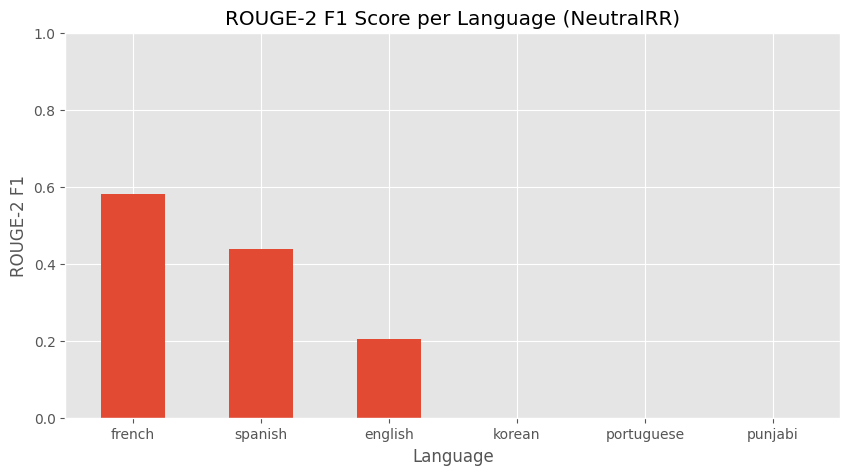

In [13]:
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use("ggplot")

# Bar chart for ROUGE-2 F1
plt.figure(figsize=(10, 5))
plt.bar(df["language"], df["rouge2_f1"], width=0.5)
plt.title("ROUGE-2 F1 Score per Language (NeutralRR)")
plt.ylabel("ROUGE-2 F1")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.show()


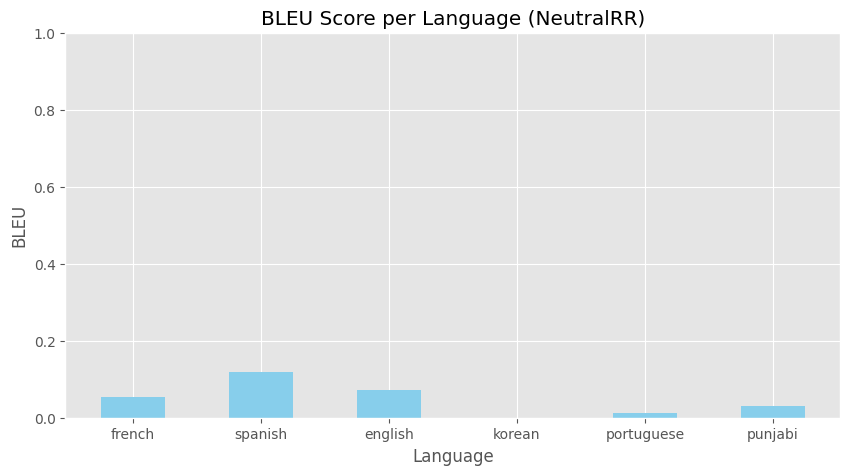

In [14]:
# Bar chart for BLEU Score
plt.figure(figsize=(10, 5))
plt.bar(df["language"], df["bleu"], width=0.5, color='skyblue')
plt.title("BLEU Score per Language (NeutralRR)")
plt.ylabel("BLEU")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.show()
